## 2. Load Data and Train a model then save the model's weight

**Used Hyperparameter**<br>
Without Data Augmentation<br>


-----------------------<br>
Level: 0,1 images <br>
Number of train,val,test: 9, 3, 3 <br>
train's stride : 299 <br>
test's stride: 299 <br>
tissue percent min: 50 <br>


In [ ]:
import numpy as np
import os
from PIL import Image
import pathlib
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from itertools import chain
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from matplotlib.patches import Rectangle
import re
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [ ]:
import os

# Initialization
lowest_level = 0
highest_level = 1
train_val_stride = 199
test_stride = 299
tissue_p_min = 50

dir = '/content/drive/MyDrive/Applied_Deep_Learning_Project/'
current_dir = 'Lev_01_split_933_stride_299_pmin_50'
saving_dir = os.path.join(dir,current_dir)
saving_dir

'/content/drive/MyDrive/Applied_Deep_Learning_Project/Lev_01_split_933_stride_299_pmin_50'

In [ ]:
# Mount drive
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)
print()

# Check TensorFlow version
import tensorflow as tf 
print("TF version: ", tf.__version__)
print()

# Check which GPU with available RAM
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

Mounted at /content/drive

TF version:  2.4.0

Found GPU at: /device:GPU:0
name, driver_version, memory.total [MiB]
Tesla V100-SXM2-16GB, 418.67, 16130 MiB


In [ ]:
zoom1_train = np.load(os.path.join(saving_dir,'zoom1_train.npy'))
zoom2_train = np.load(os.path.join(saving_dir,'zoom2_train.npy'))
label_train = np.load(os.path.join(saving_dir,'label_train.npy'))

zoom1_valid = np.load(os.path.join(saving_dir,'zoom1_valid.npy'))
zoom2_valid = np.load(os.path.join(saving_dir,'zoom2_valid.npy'))
label_valid = np.load(os.path.join(saving_dir,'label_valid.npy'))

X_train = [zoom1_train, zoom2_train]
X_valid = [zoom1_valid, zoom2_valid]
BATCH_SIZE = 32

In [ ]:
def create_inceptionv3(weights='imagenet',include_top = False, input_shape = (299,299,3)):
  base_model = tf.keras.applications.InceptionV3(weights=weights,include_top = include_top, input_shape = input_shape)
  base_model.trainable = False
  return base_model


def create_inceptionv3_fine_tune(weights='imagenet',include_top = False, input_shape = (299,299,3)):
  base_model = tf.keras.applications.InceptionV3(weights=weights,include_top = include_top, input_shape = input_shape)
  
  base_model.trainable = True
  # Let's take a look to see how many layers are in the base model
  print("Number of layers in the base InceptionV3 model: ", len(base_model.layers))
  # Fine-tune from this layer onwards
  fine_tune_at = 100
  print("Start fine tuning at layer: ", fine_tune_at)

  # Freeze all the layers before the `fine_tune_at` layer
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

  return base_model


def create_global_avg_layer():
  return tf.keras.layers.GlobalAveragePooling2D()


def create_dense_layer():
  return tf.keras.layers.Dense(1024, activation='relu')

In [ ]:
# Reference used to put multiple inputs
# # https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

def create_model_keras_inputs_two(fine_tune):

  if fine_tune:
    base_model_1 = create_inceptionv3_fine_tune()
    base_model_2 = create_inceptionv3_fine_tune()
  
  else: 
    base_model_1 = create_inceptionv3()
    base_model_2 = create_inceptionv3()

  global_avg_layer = create_global_avg_layer()
  dense_layer = create_dense_layer()

  model_1 = tf.keras.Sequential([
    base_model_1,
    global_avg_layer,
    dense_layer,
    #prediction_layer
  ])

  model_2 = tf.keras.Sequential([
    base_model_2,
    global_avg_layer,
    dense_layer,
    #prediction_layer
  ])

  input1 = Input(shape=(299,299,3))
  input2 = Input(shape=(299,299,3))
    
  model_concat = concatenate([model_1(input1) ,model_2(input2)])
  model = Dense(1024, activation='relu')(model_concat)
  model = Dense(1, activation='sigmoid')(model)
  model_final = Model(inputs=[input1,input2],outputs=model)

  return model_final

In [ ]:
# A plotting function you can reuse
def plot(history):
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  # added new version for better layout in visualization (for fun)
  fig, ax = plt.subplots(1,2, figsize = (14,5))
  ax[0].set_title('Training and validation accuracy')
  ax[0].plot(epochs, acc, color='blue', label='Train')
  ax[0].plot(epochs, val_acc, color='orange', label='Val')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()

  ax[1].set_title('Training and validation loss')
  ax[1].plot(epochs, loss, color='blue', label='Train')
  ax[1].plot(epochs, val_loss, color='orange', label='Val')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].legend()

### Version a: <br>
#### A model train with 9 train, 3 val [per image]
#### model **without** fine tuning and **without** data augmentation

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1024)         23900960    input_3[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1024)         23900960    input_4[0][0]                    
______________________________________________________________________________________________

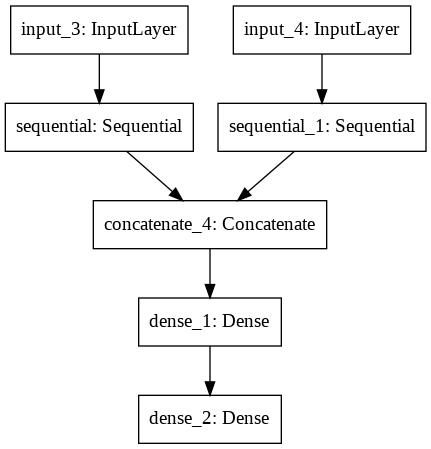

In [ ]:
mdl_9_3_wo_ft_wo_da = create_model_keras_inputs_two(fine_tune = False)
mdl_9_3_wo_ft_wo_da.summary()
display(plot_model(mdl_9_3_wo_ft_wo_da))

Epoch 1/10
907/907 [==============================] - 92s 90ms/step - loss: 3.8624 - accuracy: 0.8726 - val_loss: 0.9303 - val_accuracy: 0.6217
Epoch 2/10
907/907 [==============================] - 78s 86ms/step - loss: 0.2230 - accuracy: 0.9166 - val_loss: 0.6499 - val_accuracy: 0.7170
Epoch 3/10
907/907 [==============================] - 78s 86ms/step - loss: 0.1970 - accuracy: 0.9259 - val_loss: 1.6867 - val_accuracy: 0.5865
Epoch 4/10
907/907 [==============================] - 78s 86ms/step - loss: 0.1827 - accuracy: 0.9321 - val_loss: 0.6757 - val_accuracy: 0.6848
Epoch 5/10
907/907 [==============================] - 78s 86ms/step - loss: 0.1871 - accuracy: 0.9272 - val_loss: 0.8079 - val_accuracy: 0.6613
Epoch 6/10
907/907 [==============================] - 78s 86ms/step - loss: 0.1725 - accuracy: 0.9357 - val_loss: 0.9761 - val_accuracy: 0.6598
Epoch 7/10
907/907 [==============================] - 78s 86ms/step - loss: 0.1817 - accuracy: 0.9313 - val_loss: 0.8361 - val_accuracy:

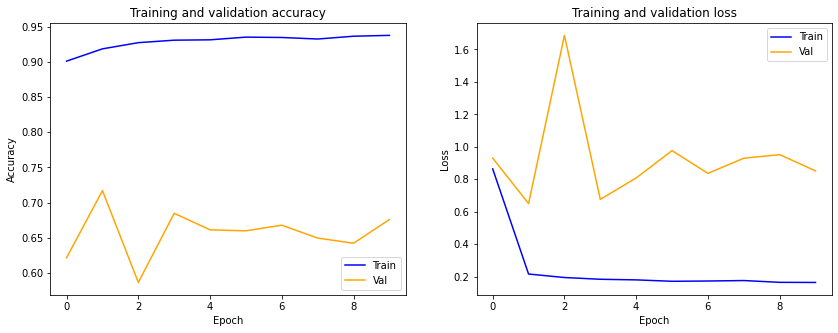

In [ ]:
mdl_9_3_wo_ft_wo_da.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

plot(mdl_9_3_wo_ft_wo_da.fit(X_train,label_train, batch_size=BATCH_SIZE,
                             validation_data =(X_valid, label_valid),  epochs=10))

In [ ]:
#save_weights
mdl_9_3_wo_ft_wo_da.save_weights(os.path.join(saving_dir,"mdl_9_3_wo_ft_wo_da.h5/"))

del mdl_9_3_wo_ft_wo_da

### Version b: <br>
#### A model train with 9 train, 3 val [per image]
#### model **with** fine tuning and **without** data augmentation

In [ ]:
mdl_9_3_w_ft_wo_da = create_model_keras_inputs_two(fine_tune = True)
mdl_9_3_w_ft_wo_da.summary()
# display(plot_model(mdl_9_3_w_ft_wo_da))

Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential_10 (Sequential)      (None, 1024)         23900960    input_23[0][0]                   
__________________________________________________________________________________________________
sequential_11 (Sequ

Epoch 1/10
907/907 [==============================] - 178s 184ms/step - loss: 0.2358 - accuracy: 0.9143 - val_loss: 1.8492 - val_accuracy: 0.5000
Epoch 2/10
907/907 [==============================] - 164s 181ms/step - loss: 0.1108 - accuracy: 0.9580 - val_loss: 34.5019 - val_accuracy: 0.6752
Epoch 3/10
907/907 [==============================] - 164s 181ms/step - loss: 0.0893 - accuracy: 0.9674 - val_loss: 1.8010 - val_accuracy: 0.6041
Epoch 4/10
907/907 [==============================] - 164s 181ms/step - loss: 0.0755 - accuracy: 0.9727 - val_loss: 0.7541 - val_accuracy: 0.7559
Epoch 5/10
907/907 [==============================] - 164s 181ms/step - loss: 0.0663 - accuracy: 0.9755 - val_loss: 2.7357 - val_accuracy: 0.5154
Epoch 6/10
907/907 [==============================] - 164s 181ms/step - loss: 0.0591 - accuracy: 0.9787 - val_loss: 1.6329 - val_accuracy: 0.6415
Epoch 7/10
907/907 [==============================] - 164s 181ms/step - loss: 0.0529 - accuracy: 0.9799 - val_loss: 1.0326 

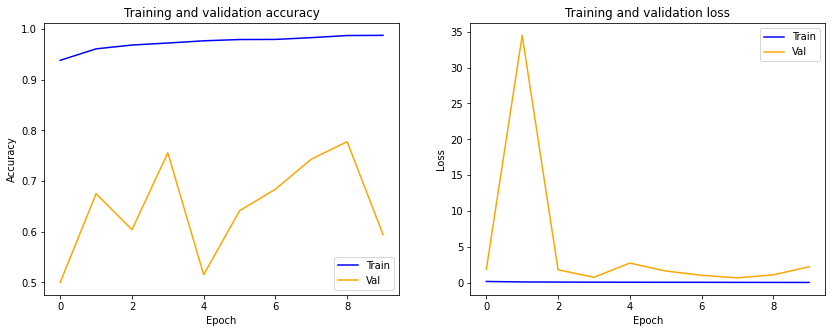

In [ ]:
mdl_9_3_w_ft_wo_da.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

plot(mdl_9_3_w_ft_wo_da.fit(X_train,label_train, batch_size=BATCH_SIZE, 
                             validation_data =(X_valid, label_valid),  epochs=10))

In [ ]:
#save_weights
mdl_9_3_w_ft_wo_da.save_weights(os.path.join(saving_dir,"mdl_9_3_w_ft_wo_da.h5/"))

del mdl_9_3_w_ft_wo_da

### Version c: <br>
#### A model train with 9 train, 3 val [per image]
#### model **without** fine tuning and **with** data augmentation

In [ ]:
# Reference used to take multiple inputs for ImageData Geneartor
# https://stackoverflow.com/questions/49404993/keras-how-to-use-fit-generator-with-multiple-inputs

# gen = ImageDataGenerator(
#     rotation_range=90,
#     shear_range=0.2)
#     # horizontal_flip = True,
#     # vertical_flip = True)

# gen_valid = ImageDataGenerator()

# def generator_two_img(X1, X2, y, batch_size):
#     genX1 = gen.flow(X1, y,  batch_size=batch_size, seed=1)
#     genX2 = gen.flow(X2, y, batch_size=batch_size, seed=1)
#     while True:
#         X1i = genX1.next()
#         X2i = genX2.next()
#         yield [X1i[0], X2i[0]], X1i[1]

# def generator_two_img_valid(X1, X2, y, batch_size):
#     genX1 = gen_valid.flow(X1, y,  batch_size=batch_size, seed=1)
#     genX2 = gen_valid.flow(X2, y, batch_size=batch_size, seed=1)
#     while True:
#         X1i = genX1.next()
#         X2i = genX2.next()
#         yield [X1i[0], X2i[0]], X1i[1]

# X_train_ = generator_two_img(zoom1_train, zoom2_train, label_train, 32)
# X_valid_ = generator_two_img_valid(zoom1_valid, zoom2_valid, label_valid, 32)
# BATCH_SIZE = 32

In [ ]:
# mdl_9_3_wo_ft_w_da = create_model_keras_inputs_two(fine_tune = False)
# mdl_9_3_wo_ft_w_da.summary()
# display(plot_model(mdl_9_3_wo_ft_w_da))

In [ ]:
# mdl_9_3_wo_ft_w_da.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

# plot(mdl_9_3_wo_ft_w_da.fit(X_train_, batch_size=BATCH_SIZE, 
#                             steps_per_epoch = len(zoom1_train)/BATCH_SIZE,
#                             validation_data =X_valid_, validation_steps = len(zoom1_valid)/BATCH_SIZE,
#                             shuffle=False, epochs=15))

In [ ]:
# #save_weights
# mdl_9_3_wo_ft_w_da.save_weights(os.path.join(saving_dir,"mdl_9_3_wo_ft_w_da.h5/"))

# del mdl_9_3_wo_ft_w_da

### Version d: <br>
#### A model train with 9 train, 3 val [per image]
#### model **with** fine tuning and **with** data augmentation

In [ ]:
# mdl_9_3_w_ft_w_da = create_model_keras_inputs_two(fine_tune = True)
# mdl_9_3_w_ft_w_da.summary()
# # display(plot_model(mdl_9_3_w_ft_w_da))

In [ ]:
# mdl_9_3_w_ft_w_da.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

# plot(mdl_9_3_w_ft_w_da.fit(X_train_, batch_size=BATCH_SIZE, 
#                 steps_per_epoch = len(zoom1_train)/BATCH_SIZE,
#                 validation_data =X_valid_, validation_steps = len(zoom1_valid)/BATCH_SIZE, 
#                 shuffle=False, epochs=15))

In [ ]:
# #save_weights
# mdl_9_3_w_ft_w_da.save_weights(os.path.join(saving_dir,"mdl_9_3_w_ft_w_da.h5/"))

# del mdl_9_3_w_ft_w_da

In [ ]:
# # Reference used to put multiple inputs
# # https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

# def create_model_keras_inputs_two_updated(fine_tune):

#   if fine_tune:
#     base_model_1 = create_inceptionv3_fine_tune()
#     base_model_2 = create_inceptionv3_fine_tune()
  
#   else: 
#     base_model_1 = create_inceptionv3()
#     base_model_2 = create_inceptionv3()

#   global_avg_layer = create_global_avg_layer()
#   dense_layer = create_dense_layer()
#   batch_norm_layer = create_batch_normalization()

#   model_1 = tf.keras.Sequential([
#     base_model_1,
#     global_avg_layer,
#     dense_layer,
#     #prediction_layer
#   ])

#   model_2 = tf.keras.Sequential([
#     base_model_2,
#     global_avg_layer,
#     dense_layer,
#     #prediction_layer
#   ])

#   input1 = Input(shape=(299,299,3))
#   input2 = Input(shape=(299,299,3))
    
#   model = concatenate([model_1(input1) ,model_2(input2)], axis =1)
  
#   model = tf.keras.layers.BatchNormalization()(model)
#   model = tf.keras.layers.Dropout(0.3)(model)
#   model = Dense(1024, activation='relu')(model)
  
#   model = tf.keras.layers.BatchNormalization()(model)
#   model = tf.keras.layers.Dropout(0.3)(model)
#   model = Dense(128, activation='relu')(model)
  
#   model = tf.keras.layers.BatchNormalization()(model)
#   model = tf.keras.layers.Dropout(0.3)(model)
#   model = Dense(1, activation='sigmoid')(model)

#   model_final = Model(inputs=[input1,input2],outputs=model)

#   return model_final

### Version 2.a: Batch Normalization <br>
#### A model train with 9 train, 3 val [per image]
#### model **without** fine tuning and **without** data augmentation 
#### **Also** added Batch Normalization and extra dense layer

In [ ]:
def add_layers(model, add_BN, add_Dropout):
  if add_BN:
    if add_Dropout:
      print("Added BN and Dropout")
      model = tf.keras.layers.BatchNormalization()(model)
      model = tf.keras.layers.Dropout(0.3)(model)
      model = Dense(1024, activation='relu')(model)
      model = tf.keras.layers.BatchNormalization()(model)
      model = tf.keras.layers.Dropout(0.3)(model)
      model = Dense(128, activation='relu')(model)
      model = tf.keras.layers.BatchNormalization()(model)
      model = tf.keras.layers.Dropout(0.3)(model)
      model = Dense(1, activation='sigmoid')(model)
      return model
    
    else: # i.e. only add Batch Normalization
      print("Added only BN")
      model = tf.keras.layers.BatchNormalization()(model)
      model = Dense(1024, activation='relu')(model)
      model = tf.keras.layers.BatchNormalization()(model)
      model = Dense(128, activation='relu')(model)
      model = tf.keras.layers.BatchNormalization()(model)
      model = Dense(1, activation='sigmoid')(model)
      return model

    
  else: # i.e. only apply Dropout
    print("Added only Dropout")
    model = tf.keras.layers.Dropout(0.3)(model)
    model = Dense(1024, activation='relu')(model)
    model = tf.keras.layers.Dropout(0.3)(model)
    model = Dense(128, activation='relu')(model)
    model = tf.keras.layers.Dropout(0.3)(model)
    model = Dense(1, activation='sigmoid')(model)
    return model

In [ ]:
# Reference used to put multiple inputs
# https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

def create_model_keras_inputs_two_updated(fine_tune, add_BN, add_Dropout):

  if fine_tune:
    base_model_1 = create_inceptionv3_fine_tune()
    base_model_2 = create_inceptionv3_fine_tune()
  
  else: 
    base_model_1 = create_inceptionv3()
    base_model_2 = create_inceptionv3()

  global_avg_layer = create_global_avg_layer()
  dense_layer = create_dense_layer()

  model_1 = tf.keras.Sequential([
    base_model_1,
    global_avg_layer,
    dense_layer,
    #prediction_layer
  ])

  model_2 = tf.keras.Sequential([
    base_model_2,
    global_avg_layer,
    dense_layer,
    #prediction_layer
  ])

  input1 = Input(shape=(299,299,3))
  input2 = Input(shape=(299,299,3))
    
  model = concatenate([model_1(input1) ,model_2(input2)], axis =1)
  model = add_layers(model = model, add_BN = add_BN, add_Dropout = add_Dropout)
  model_final = Model(inputs=[input1,input2],outputs=model)

  return model_final

Added only BN
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 1024)         23900960    input_27[0][0]                   
__________________________________________________________________________________________________
sequential_13 (Sequential)      (None, 1024)         23900960    input_28[0][0]                   
______________________________________________________________________________

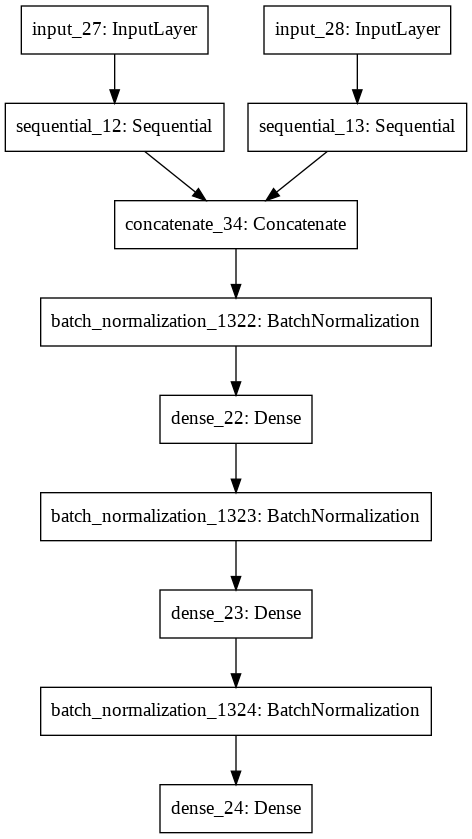

In [ ]:
mdl_9_3_wo_ft_wo_da_BN = create_model_keras_inputs_two_updated(fine_tune = False, add_BN = True, add_Dropout = False)
mdl_9_3_wo_ft_wo_da_BN.summary()
display(plot_model(mdl_9_3_wo_ft_wo_da_BN))

Epoch 1/10
907/907 [==============================] - 91s 90ms/step - loss: 0.2324 - accuracy: 0.9135 - val_loss: 0.8379 - val_accuracy: 0.6628
Epoch 2/10
907/907 [==============================] - 79s 87ms/step - loss: 0.1802 - accuracy: 0.9296 - val_loss: 0.5350 - val_accuracy: 0.7559
Epoch 3/10
907/907 [==============================] - 79s 87ms/step - loss: 0.1600 - accuracy: 0.9370 - val_loss: 0.7650 - val_accuracy: 0.7251
Epoch 4/10
907/907 [==============================] - 79s 87ms/step - loss: 0.1418 - accuracy: 0.9460 - val_loss: 0.7571 - val_accuracy: 0.7126
Epoch 5/10
907/907 [==============================] - 79s 87ms/step - loss: 0.1445 - accuracy: 0.9452 - val_loss: 0.5901 - val_accuracy: 0.7478
Epoch 6/10
907/907 [==============================] - 79s 87ms/step - loss: 0.1332 - accuracy: 0.9483 - val_loss: 1.2611 - val_accuracy: 0.6694
Epoch 7/10
907/907 [==============================] - 79s 87ms/step - loss: 0.1257 - accuracy: 0.9527 - val_loss: 1.3130 - val_accuracy:

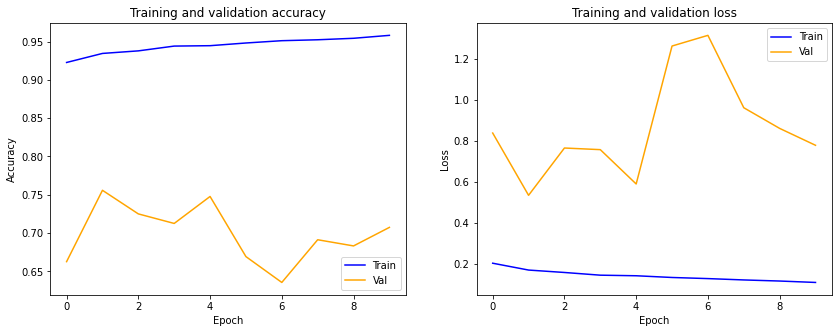

In [ ]:
mdl_9_3_wo_ft_wo_da_BN.compile(optimizer=Adam(learning_rate=0.0005),loss='binary_crossentropy',metrics=['accuracy'])

plot(mdl_9_3_wo_ft_wo_da_BN.fit(X_train,label_train, 
                batch_size=BATCH_SIZE, 
                validation_data =(X_valid, label_valid),  epochs=10))

In [ ]:
#save_weights
mdl_9_3_wo_ft_wo_da_BN.save_weights(os.path.join(saving_dir,"mdl_9_3_wo_ft_wo_da_BN.h5/"))

del mdl_9_3_wo_ft_wo_da_BN

### Version 2.b: Dropout <br>
#### A model train with 9 train, 3 val [per image]
#### model **without** fine tuning and **without** data augmentation 
#### **Also** added Dropout and extra dense layer

Added only Dropout
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential_14 (Sequential)      (None, 1024)         23900960    input_31[0][0]                   
__________________________________________________________________________________________________
sequential_15 (Sequential)      (None, 1024)         23900960    input_32[0][0]                   
_________________________________________________________________________

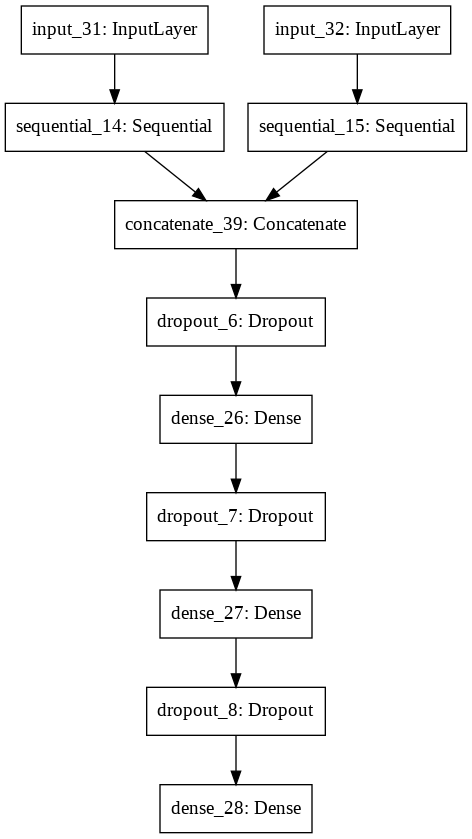

In [ ]:
mdl_9_3_wo_ft_wo_da_Dropout = create_model_keras_inputs_two_updated(fine_tune = False, add_BN = False, add_Dropout = True)
mdl_9_3_wo_ft_wo_da_Dropout.summary()
display(plot_model(mdl_9_3_wo_ft_wo_da_Dropout))

Epoch 1/10
907/907 [==============================] - 90s 89ms/step - loss: 1.5132 - accuracy: 0.8488 - val_loss: 0.7163 - val_accuracy: 0.7060
Epoch 2/10
907/907 [==============================] - 78s 86ms/step - loss: 0.2569 - accuracy: 0.9087 - val_loss: 0.7602 - val_accuracy: 0.6979
Epoch 3/10
907/907 [==============================] - 78s 86ms/step - loss: 0.2354 - accuracy: 0.9144 - val_loss: 0.7301 - val_accuracy: 0.6943
Epoch 4/10
907/907 [==============================] - 78s 86ms/step - loss: 0.2297 - accuracy: 0.9182 - val_loss: 0.6260 - val_accuracy: 0.6826
Epoch 5/10
907/907 [==============================] - 78s 86ms/step - loss: 0.2228 - accuracy: 0.9210 - val_loss: 0.5818 - val_accuracy: 0.7060
Epoch 6/10
907/907 [==============================] - 78s 86ms/step - loss: 0.2187 - accuracy: 0.9213 - val_loss: 0.6969 - val_accuracy: 0.6921
Epoch 7/10
907/907 [==============================] - 78s 86ms/step - loss: 0.2029 - accuracy: 0.9245 - val_loss: 0.8576 - val_accuracy:

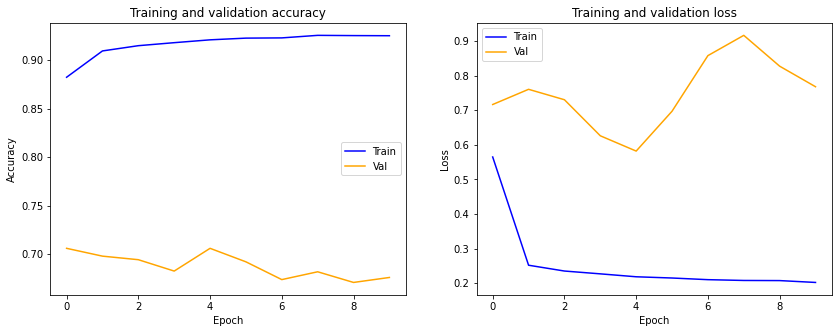

In [ ]:
mdl_9_3_wo_ft_wo_da_Dropout.compile(optimizer=Adam(learning_rate=0.0005),loss='binary_crossentropy',metrics=['accuracy'])


plot(mdl_9_3_wo_ft_wo_da_Dropout.fit(X_train,label_train, 
                batch_size=BATCH_SIZE, 
                validation_data =(X_valid, label_valid),  epochs=10))

In [ ]:
#save_weights
mdl_9_3_wo_ft_wo_da_Dropout.save_weights(os.path.join(saving_dir,"mdl_9_3_wo_ft_wo_da_Dropout.h5/"))

del mdl_9_3_wo_ft_wo_da_Dropout

### Version 2.c: Batch Norm + Dropout <br>
#### A model train with 9 train, 3 val [per image]
#### model **without** fine tuning and **without** data augmentation 
#### **Also** added Batch Normailzation, Dropout, and extra dense layer

Added BN and Dropout
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential_16 (Sequential)      (None, 1024)         23900960    input_35[0][0]                   
__________________________________________________________________________________________________
sequential_17 (Sequential)      (None, 1024)         23900960    input_36[0][0]                   
_______________________________________________________________________

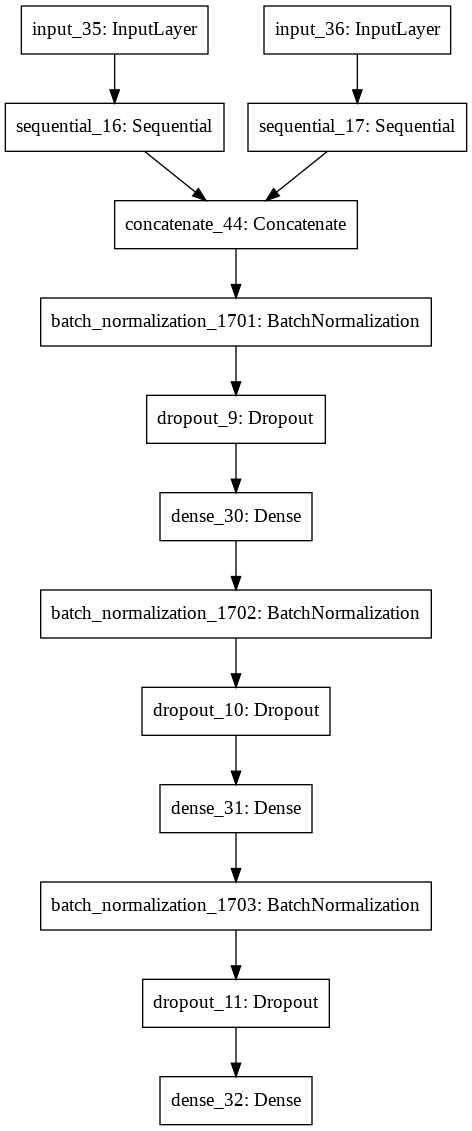

In [ ]:
mdl_9_3_wo_ft_wo_da_BN_DO = create_model_keras_inputs_two_updated(fine_tune = False, add_BN = True, add_Dropout = True)
mdl_9_3_wo_ft_wo_da_BN_DO.summary()
display(plot_model(mdl_9_3_wo_ft_wo_da_BN_DO))

Epoch 1/10
907/907 [==============================] - 90s 89ms/step - loss: 0.2744 - accuracy: 0.9004 - val_loss: 0.8621 - val_accuracy: 0.6701
Epoch 2/10
907/907 [==============================] - 79s 87ms/step - loss: 0.1868 - accuracy: 0.9285 - val_loss: 0.6977 - val_accuracy: 0.7038
Epoch 3/10
907/907 [==============================] - 79s 87ms/step - loss: 0.1801 - accuracy: 0.9317 - val_loss: 0.9324 - val_accuracy: 0.6686
Epoch 4/10
907/907 [==============================] - 79s 87ms/step - loss: 0.1706 - accuracy: 0.9358 - val_loss: 0.7512 - val_accuracy: 0.6848
Epoch 5/10
907/907 [==============================] - 79s 87ms/step - loss: 0.1647 - accuracy: 0.9387 - val_loss: 0.9015 - val_accuracy: 0.6745
Epoch 6/10
907/907 [==============================] - 79s 87ms/step - loss: 0.1612 - accuracy: 0.9394 - val_loss: 1.0092 - val_accuracy: 0.6356
Epoch 7/10
907/907 [==============================] - 79s 87ms/step - loss: 0.1530 - accuracy: 0.9411 - val_loss: 0.7101 - val_accuracy:

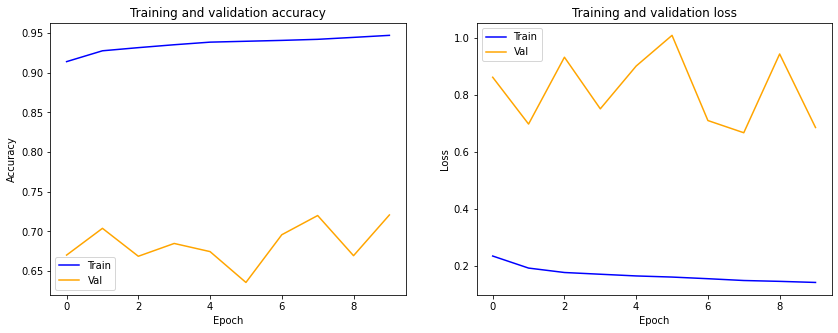

In [ ]:
mdl_9_3_wo_ft_wo_da_BN_DO.compile(optimizer=Adam(learning_rate=0.0005),loss='binary_crossentropy',metrics=['accuracy'])


plot(mdl_9_3_wo_ft_wo_da_BN_DO.fit(X_train,label_train, 
                batch_size=BATCH_SIZE, 
                validation_data =(X_valid, label_valid),  epochs=10))

In [ ]:
#save_weights
mdl_9_3_wo_ft_wo_da_BN_DO.save_weights(os.path.join(saving_dir,"mdl_9_3_wo_ft_wo_da_BN_DO.h5/"))

del mdl_9_3_wo_ft_wo_da_BN_DO